In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import calendar
from datetime import date

%run ../db.py
%run ../database.py
%run ../utils.py

In [2]:
cgreen = '#27ae60'
cblue = '#2980b9'
cred = '#c0392b'
corange = '#d35400'
cgrey = '#7f8c8d'
cdark = '#2c3e50'
cwithe = '#ecf0f1'

figsize = (10, 6)

In [3]:
spec = {
    'data_base': 'Mês',
    'dotacao_inicial': 'Dotação Inicial',
    'dotacao_atualizada': 'Dotação Atualizada',
    'empenhado': 'Empenhado',
    'liquidado': 'Liquidado',
    'pago': 'Pago',
    'dotacao_a_empenhar': 'A Empenhar',
    'empenhado_a_liquidar': 'A Liquidar',
    'liquidado_a_pagar': 'A Pagar'
}
fmt = {
    'data_base': date_to_month_name,
    'dotacao_inicial': money_formatter,
    'dotacao_atualizada': money_formatter,
    'empenhado': money_formatter,
    'liquidado': money_formatter,
    'pago': money_formatter,
    'dotacao_a_empenhar': money_formatter,
    'empenhado_a_liquidar': money_formatter,
    'liquidado_a_pagar': money_formatter
}

In [4]:
def plot_acumulado(df, titulo):
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(titulo, x=0, fontsize=16)
    plt.title('valores acumulados', x=0)
    x = df['data_base'].dt.strftime('%b')
    plt.plot(x, df['dotacao_atualizada'], color=cblue, label='Dotação', linestyle='--')
    plt.plot(x, df['empenhado'], color=cred, label="Empenhado", marker='o')
    plt.plot(x, df['liquidado'], color=corange, label='Liquidado', marker='^')
    plt.plot(x, df['pago'], color=cgrey, label='Pago', marker='s')
    plt.ylim(bottom=0)
    plt.xticks(x)
    ax.yaxis.set_major_formatter(int_formatter)
    plt.legend(loc='best', ncol=4)
    plt.show()
    
def adiciona_data_base(df):
    last_day_of_month = []
    for month in range(df['data_base'].max().month + 1, 13):
        last_day_of_month.append(date(2023, month, calendar.monthrange(2023, month)[1]))
    for dt in last_day_of_month:
        n = pd.DataFrame([{'data_base': dt}])
        df = pd.concat([df, n])
    df = df.reset_index(drop=True)
    #df = df.drop('index', axis=1)
    return df
    


# Despesas

Nesta parte são demonstradas as despesas da **Prefeitura**, excluídas, portanto, as receias do *RPPS* e da *Câmara de Vereadores*. As despesas *intra-orçamentárias* executadas são incluídas nos valores.

## Despesa Total

In [5]:
nome_despesa = 'Despesa Total'
sql = f'''
SELECT
    data_final AS data_base,
    SUM(dotacao_inicial) AS dotacao_inicial,
    SUM(dotacao_atualizada) AS dotacao_atualizada,
    SUM(valor_empenhado) AS empenhado,
    SUM(valor_liquidado) AS liquidado,
    SUM(valor_pago) AS pago,
    SUM(dotacao_a_empenhar) AS dotacao_a_empenhar,
    SUM(empenhado_a_liquidar) AS empenhado_a_liquidar,
    SUM(liquidado_a_pagar) AS liquidado_a_pagar
FROM pad."BAL_DESP"
WHERE
    controle BETWEEN {controle_ano}01 AND {controle_mes}
    AND entidade LIKE 'pm'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
despesa_atual = sqldf(sql)

despesa = adiciona_data_base(despesa_atual)
despesa['data_base'] = pd.to_datetime(despesa['data_base'], format='%Y-%m-%d')


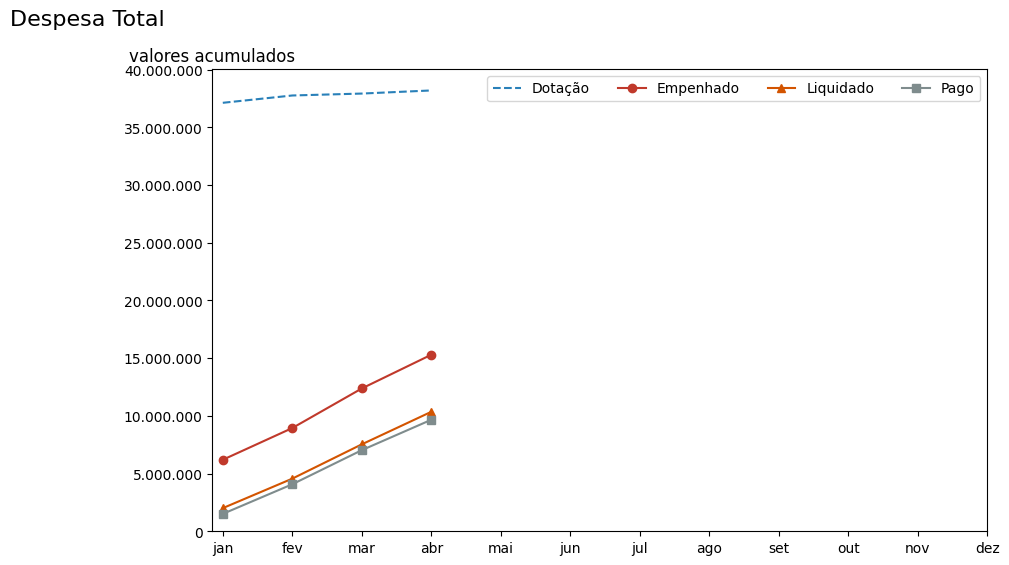

In [6]:
acumulado = despesa.copy()
plot_acumulado(acumulado, nome_despesa)

In [7]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_despesa} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,Dotação Inicial,Dotação Atualizada,Empenhado,Liquidado,Pago,A Empenhar,A Liquidar,A Pagar
jan,"36.470.656,34","37.128.606,73","6.197.367,20","2.005.989,99","1.507.474,02","30.931.239,53","4.191.377,21","498.515,97"
fev,"36.470.656,34","37.762.895,12","8.946.915,37","4.562.103,04","4.075.190,58","28.815.979,75","4.384.812,33","486.912,46"
mar,"36.470.656,34","37.929.536,81","12.375.697,50","7.535.530,49","7.029.441,27","25.553.839,31","4.840.167,01","506.089,22"
abr,"36.470.656,34","38.199.202,82","15.299.155,37","10.354.188,19","9.665.168,46","22.900.047,45","4.944.967,18","689.019,73"
mai,,,,,,,,
jun,,,,,,,,
jul,,,,,,,,
ago,,,,,,,,
set,,,,,,,,
out,,,,,,,,


## Despesa Corrente

In [8]:
nome_despesa = 'Despesa Corrente'
sql = f'''
SELECT
    data_final AS data_base,
    SUM(dotacao_inicial) AS dotacao_inicial,
    SUM(dotacao_atualizada) AS dotacao_atualizada,
    SUM(valor_empenhado) AS empenhado,
    SUM(valor_liquidado) AS liquidado,
    SUM(valor_pago) AS pago,
    SUM(dotacao_a_empenhar) AS dotacao_a_empenhar,
    SUM(empenhado_a_liquidar) AS empenhado_a_liquidar,
    SUM(liquidado_a_pagar) AS liquidado_a_pagar
FROM pad."BAL_DESP"
WHERE
    controle BETWEEN {controle_ano}01 AND {controle_mes}
    AND entidade LIKE 'pm'
    AND elemento LIKE '3%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
despesa_atual = sqldf(sql)

despesa = adiciona_data_base(despesa_atual)
despesa['data_base'] = pd.to_datetime(despesa['data_base'], format='%Y-%m-%d')


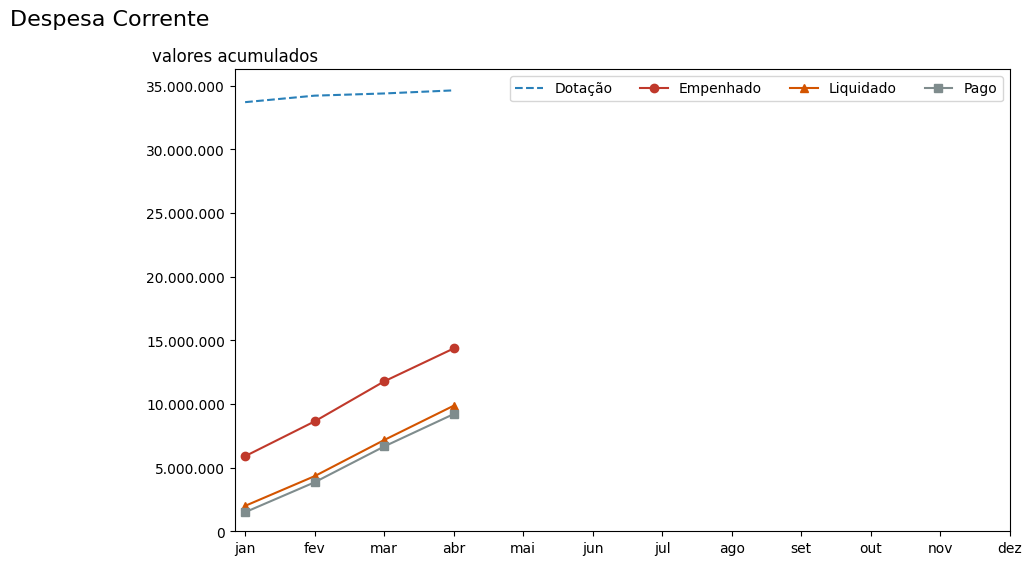

In [9]:
acumulado = despesa.copy()
plot_acumulado(acumulado, nome_despesa)

In [10]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_despesa} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,Dotação Inicial,Dotação Atualizada,Empenhado,Liquidado,Pago,A Empenhar,A Liquidar,A Pagar
jan,"32.803.952,72","33.718.131,17","5.900.128,54","1.996.508,43","1.497.992,46","27.818.002,63","3.903.620,11","498.515,97"
fev,"32.803.952,72","34.228.971,67","8.633.003,54","4.331.507,81","3.849.803,35","25.595.968,13","4.301.495,73","481.704,46"
mar,"32.803.952,72","34.401.169,07","11.775.771,58","7.167.970,66","6.661.881,44","22.625.397,49","4.607.800,92","506.089,22"
abr,"32.803.952,72","34.644.293,51","14.362.576,12","9.863.859,72","9.207.689,99","20.281.717,39","4.498.716,40","656.169,73"
mai,,,,,,,,
jun,,,,,,,,
jul,,,,,,,,
ago,,,,,,,,
set,,,,,,,,
out,,,,,,,,


## Despesa com Pessoal e Encargos Sociais

In [11]:
nome_despesa = 'Despesa Corrente'
sql = f'''
SELECT
    data_final AS data_base,
    SUM(dotacao_inicial) AS dotacao_inicial,
    SUM(dotacao_atualizada) AS dotacao_atualizada,
    SUM(valor_empenhado) AS empenhado,
    SUM(valor_liquidado) AS liquidado,
    SUM(valor_pago) AS pago,
    SUM(dotacao_a_empenhar) AS dotacao_a_empenhar,
    SUM(empenhado_a_liquidar) AS empenhado_a_liquidar,
    SUM(liquidado_a_pagar) AS liquidado_a_pagar
FROM pad."BAL_DESP"
WHERE
    controle BETWEEN {controle_ano}01 AND {controle_mes}
    AND entidade LIKE 'pm'
    AND elemento LIKE '31%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
despesa_atual = sqldf(sql)

despesa = adiciona_data_base(despesa_atual)
despesa['data_base'] = pd.to_datetime(despesa['data_base'], format='%Y-%m-%d')


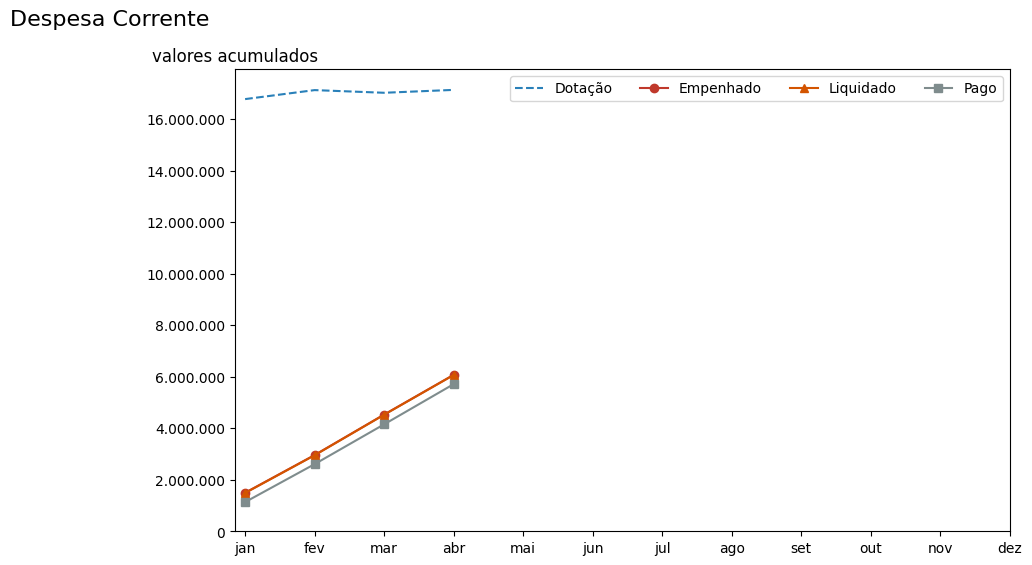

In [12]:
acumulado = despesa.copy()
plot_acumulado(acumulado, nome_despesa)

In [13]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_despesa} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,Dotação Inicial,Dotação Atualizada,Empenhado,Liquidado,Pago,A Empenhar,A Liquidar,A Pagar
jan,"16.506.989,00","16.777.735,24","1.496.230,07","1.485.230,07","1.133.348,52","15.281.505,17","11.000,00","351.881,55"
fev,"16.506.989,00","17.126.735,24","2.960.129,66","2.950.464,13","2.606.920,54","14.166.605,58","9.665,53","343.543,59"
mar,"16.506.989,00","17.023.325,24","4.531.645,32","4.523.109,57","4.152.058,91","12.491.679,92","8.535,75","371.050,66"
abr,"16.506.989,00","17.135.325,24","6.073.106,83","6.065.700,86","5.711.689,57","11.062.218,41","7.405,97","354.011,29"
mai,,,,,,,,
jun,,,,,,,,
jul,,,,,,,,
ago,,,,,,,,
set,,,,,,,,
out,,,,,,,,


## Despesa de Custeio

Outras despesas correntes, exceto pessoal, encargos sociais e juros da dívida.

In [14]:
nome_despesa = 'Despesa de Custeio'
sql = f'''
SELECT
    data_final AS data_base,
    SUM(dotacao_inicial) AS dotacao_inicial,
    SUM(dotacao_atualizada) AS dotacao_atualizada,
    SUM(valor_empenhado) AS empenhado,
    SUM(valor_liquidado) AS liquidado,
    SUM(valor_pago) AS pago,
    SUM(dotacao_a_empenhar) AS dotacao_a_empenhar,
    SUM(empenhado_a_liquidar) AS empenhado_a_liquidar,
    SUM(liquidado_a_pagar) AS liquidado_a_pagar
FROM pad."BAL_DESP"
WHERE
    controle BETWEEN {controle_ano}01 AND {controle_mes}
    AND entidade LIKE 'pm'
    AND elemento LIKE '33%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
despesa_atual = sqldf(sql)

despesa = adiciona_data_base(despesa_atual)
despesa['data_base'] = pd.to_datetime(despesa['data_base'], format='%Y-%m-%d')


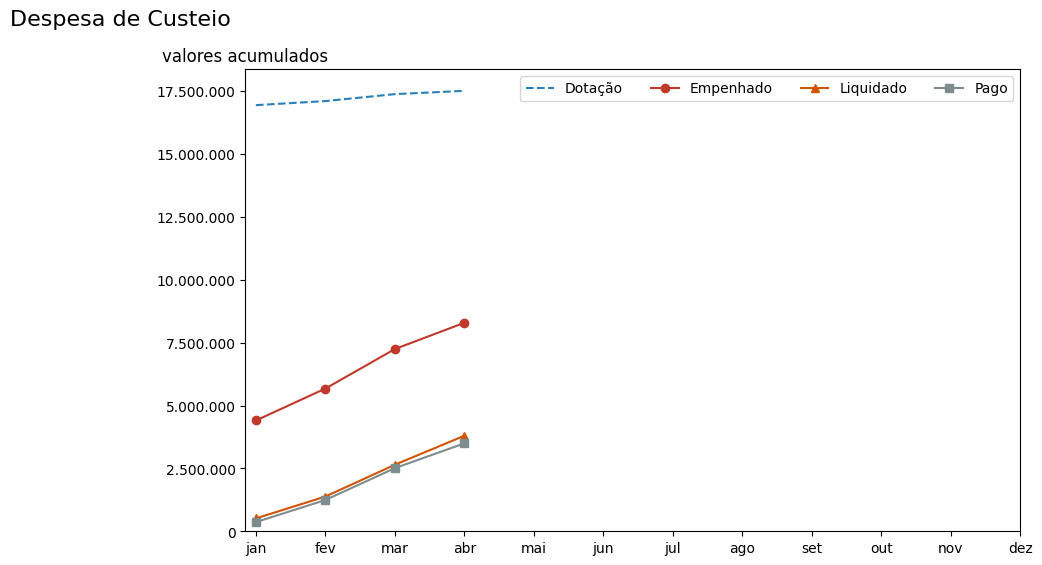

In [15]:
acumulado = despesa.copy()
plot_acumulado(acumulado, nome_despesa)

In [16]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_despesa} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,Dotação Inicial,Dotação Atualizada,Empenhado,Liquidado,Pago,A Empenhar,A Liquidar,A Pagar
jan,"16.296.963,72","16.940.395,93","4.403.898,47","511.278,36","364.643,94","12.536.497,46","3.892.620,11","146.634,42"
fev,"16.296.963,72","17.102.236,43","5.672.873,88","1.381.043,68","1.242.882,81","11.429.362,55","4.291.830,20","138.160,87"
mar,"16.296.963,72","17.377.843,83","7.244.126,26","2.644.861,09","2.509.822,53","10.133.717,57","4.599.265,17","135.038,56"
abr,"16.296.963,72","17.508.968,27","8.289.469,29","3.798.158,86","3.496.000,42","9.219.498,98","4.491.310,43","302.158,44"
mai,,,,,,,,
jun,,,,,,,,
jul,,,,,,,,
ago,,,,,,,,
set,,,,,,,,
out,,,,,,,,


## Despesa por Órgãos

In [17]:
nome_despesa = 'Despesa por Órgãos'
sql = f'''
SELECT
    nome_orgao,
    SUM(valor_liquidado) AS liquidado
FROM pad."BAL_DESP"
WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
GROUP BY
    nome_orgao
ORDER BY
    liquidado DESC
'''
#print(sql)
despesa_atual = sqldf(sql)

despesa = despesa_atual


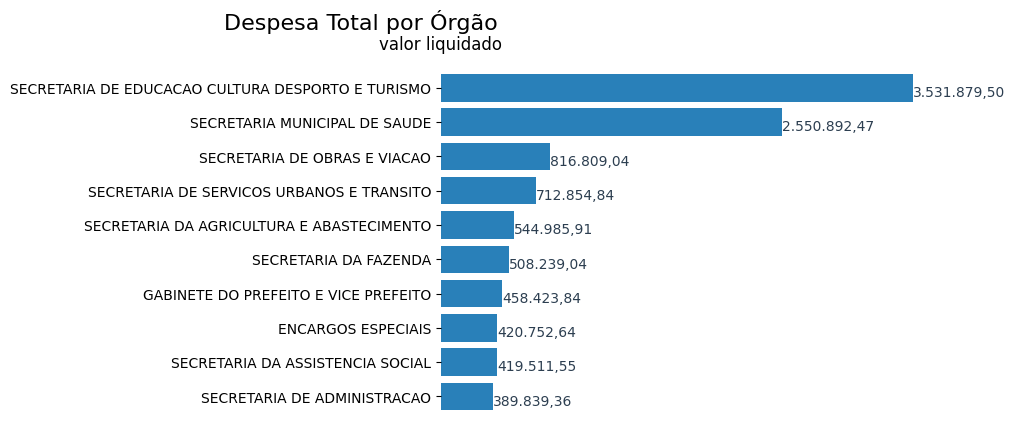

In [18]:
fig, ax = plt.subplots()
fig.suptitle('Despesa Total por Órgão', x=0, fontsize=16)
plt.title('valor liquidado', x=0)
orgaos = despesa['nome_orgao']
ax.barh(orgaos, despesa['liquidado'], color=cblue)
ax.invert_yaxis()
for i, v in enumerate(despesa['liquidado']):
    ax.text(v + 3, i + 0.25, money_formatter(v), color=cdark)
ax.set_xticks([])
ax.set_frame_on(False)
plt.show()

In [19]:
df = df_table(despesa.copy(), spec={
    'nome_orgao': 'Órgão',
    'liquidado': 'Liquidado'
}, fmt={
    'liquidado': money_formatter
})
df.style.set_caption(f'{nome_despesa} - valores acumulados - {dt.year}').hide(axis='index')
#df

Órgão,Liquidado
SECRETARIA DE EDUCACAO CULTURA DESPORTO E TURISMO,"3.531.879,50"
SECRETARIA MUNICIPAL DE SAUDE,"2.550.892,47"
SECRETARIA DE OBRAS E VIACAO,"816.809,04"
SECRETARIA DE SERVICOS URBANOS E TRANSITO,"712.854,84"
SECRETARIA DA AGRICULTURA E ABASTECIMENTO,"544.985,91"
SECRETARIA DA FAZENDA,"508.239,04"
GABINETE DO PREFEITO E VICE PREFEITO,"458.423,84"
ENCARGOS ESPECIAIS,"420.752,64"
SECRETARIA DA ASSISTENCIA SOCIAL,"419.511,55"
SECRETARIA DE ADMINISTRACAO,"389.839,36"
